In [1]:
import os
import time
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from dask_ml.wrappers import ParallelPostFit  # wrapper so that model predicts using dask

from joblib import dump

import model_prep_and_evals as mpe # custom module

In [9]:
split = True
whole_set = False

In [10]:
if split == True:
    # ------------------------------
    # Import train data

    # select features from red to avg_lidar // excludes geometry, aoi, naip_id, polygon)id and iceplant features
    X_train = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','train_set.csv')).loc[:,'r':'avg_lidar']

    # select iceplant feature column
    y_train = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','train_set.csv')).loc[:,'iceplant'] 

    # remove 2012 and 2014 since these do not have LIDAR data of their own.
    X_train = X_train.loc[X_train.year != 2012]
    X_train = X_train.loc[X_train.year != 2014]

    y_train = y_train.iloc[X_train.index]

    # ------------------------------
    # Import test data

    # select features from r (Red band) to avg_lidar // excludes geometry, aoi, naip_id, polygon)id and iceplant features
    X_test = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','test_set.csv')).loc[:,'r':'avg_lidar']

    # select iceplant feature column
    y_test = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','test_set.csv')).loc[:,'iceplant'] 

    # remove 2012 and 2014 since these do not have LIDAR data of their own.
    X_test = X_test.loc[X_test.year != 2012]
    X_test = X_test.loc[X_test.year != 2014]

    y_test = y_test.iloc[X_test.index]

    # ------------------------------
    if whole_set == True:
        X_train = pd.concat([X_train, X_test], axis = 0)
        y_train = pd.concat([y_train, y_test], axis = 0)

    # ------------------------------    
    # feature_names = X_train.columns.to_list()
    # print(feature_names)


In [11]:
# y_train.index

# X_train.index

X_train = X_train.loc[(X_train["lidar"] >= 0) & 
                        (X_train["max_lidar"] >= 0) &
                        (X_train["min_lidar"] >= 0) &
                        (X_train["avg_lidar"] >= 0) &
                        (X_train["min_max_diff"] >= 0)
                       ]

y_train = y_train.loc[X_train.index]
y_train

0         1
1         1
2         0
3         0
4         1
         ..
285504    1
285505    1
285506    0
285507    1
285508    1
Name: iceplant, Length: 226408, dtype: int64

In [13]:
X_train.drop('avg_lidar',axis = 1, inplace=True)
X_train

,r,g,b,nir,ndvi,year,month,day_in_year,lidar,max_lidar,min_lidar,min_max_diff
0,42,42,46,117,0.471698,2016,7,195,0.0,1.0,0.0,1.0
1,61,54,62,75,0.102941,2016,7,195,1.0,2.0,1.0,1.0
2,65,67,58,164,0.432314,2016,7,195,0.0,1.0,0.0,1.0
3,81,71,68,130,0.232227,2016,7,195,0.0,0.0,0.0,0.0
4,48,44,50,107,0.380645,2016,7,195,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
285504,137,105,81,175,0.121795,2020,6,159,0.0,5.0,0.0,5.0
285505,116,91,63,176,0.205479,2020,6,159,0.0,2.0,0.0,2.0
285506,58,53,45,115,0.329480,2020,6,159,30.0,38.0,17.0,21.0
285507,144,104,84,163,0.061889,2020,6,159,0.0,0.0,0.0,0.0


In [ ]:
# #neg_index = X_train.loc[X_train.avg_lidar<0].index
# X_train.loc[X_train.min_lidar<0, 'avg_lidar'] = 0
# X_train.loc[X_train.min_lidar<0]

In [ ]:
if split == False:
    #------------------------------
    # Import train data
    X_train = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','samples_for_model.csv')).loc[:,'r':'avg_lidar']
    # select iceplant feature column
    y_train = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','samples_for_model.csv')).loc[:,'iceplant'] 

    # remove 2012 and 2014 since these do not have LIDAR data of their own.
    X_train = X_train.loc[X_train.year != 2012]
    X_train = X_train.loc[X_train.year != 2014]

    y_train = y_train.iloc[X_train.index]

In [14]:
# ------------------------------
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [15]:
rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, 
                                             random_state = 42))
rfc.fit(X_train, y_train)
dump(rfc, 'lidar_spectral_rfc3.joblib')

['lidar_spectral_rfc3.joblib']

In [21]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc, 
#    X_test.drop('avg_lidar',  axis = 1,inplace=True),
    X_test.to_numpy(),
    y_test.to_numpy(),
    n_repeats=10, 
    random_state=42, 
    n_jobs=2
)

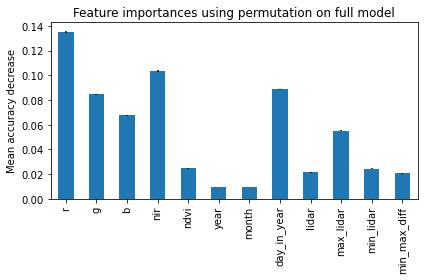

In [22]:
import matplotlib.pyplot as plt

forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()